In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import random
import shap
shap.initjs()

In [89]:
# Defining hyperparameters
TRAIN_BATCH_SIZE = 16
VAL_TEST_BATCH_SIZE = 32
LEARNING_RATE = .001
SEED = 42

# Setting the seed for reproducability
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(SEED)

# Creating variables to store numerical and categorical feature names
numerical_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']
all_vars = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

In [ ]:
# Load the data
df_train_val = pd.read_parquet('data/train_val.parquet')
df_test = pd.read_parquet('data/test.parquet')

# Scaling the numerical variables with min-max scaler and creating numpy arrays from them
scaler = MinMaxScaler()

X_train_val = df_train_val.drop('HeartDisease', axis=1)
X_train_val[numerical_vars] = scaler.fit_transform(X_train_val[numerical_vars])
X_train_val = X_train_val.to_numpy()
X_test = df_test.drop('HeartDisease', axis=1)
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])
X_test = X_test.to_numpy()

# Getting the target values from the data frames
y_train_val = df_train_val['HeartDisease'].to_numpy()
y_test = df_test['HeartDisease'].to_numpy()

# Transforming the arrays to tensors
X_train_val = torch.from_numpy(X_train_val).float()
y_train_val = torch.from_numpy(y_train_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Splitting train_val set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.2, random_state=42, shuffle=True)

# Reshaping the outcomes to column vectors
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
#y_train_val = y_train_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Creating datasets from the tensors
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
#train_val_data = TensorDataset(X_train_val, y_train_val)
test_data = TensorDataset(X_test, y_test)

# Creating data loaders for the datasets
train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)
#train_val_dataloader = DataLoader(train_val_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)

In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    """
    Trains a model for one epoch.

    Parameters:
    -----------
    dataloader : torch.utils.data.DataLoader
        The DataLoader providing the training data in batches.
    model : torch.nn.Module
        The PyTorch model to be trained.
    loss_fn : callable
        The loss function used to compute the difference between predictions and targets.
    optimizer : torch.optim.Optimizer
        The optimizer used to update model weights.

    Returns:
    --------
    None
    """

    size = len(dataloader.dataset) # Total number of samples in the dataset

    # Set the model to training mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print progress every 10 batches
        if batch % 10 == 0:
            loss_value = loss.item()  # Convert tensor to scalar for logging
            current = batch * dataloader.batch_size + len(X)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")


def evaluate_model(dataloader, model, loss_fn):
    """
    Evaluates a trained model on a given dataset.

    Parameters:
    -----------
    dataloader : torch.utils.data.DataLoader
        The DataLoader providing the evaluation data in batches.
    model : torch.nn.Module
        The PyTorch model to be evaluated.
    loss_fn : callable
        The loss function used to compute the loss between predictions and targets.

    Returns:
    --------
    loss : float
        Average loss over the dataset.
    f1 : float
        F1 score of the predictions.
    balanced_acc : float
        Balanced accuracy score of the predictions.
    """
    
    # Total number of samples and batches
    size = len(dataloader.dataset)
    num_batches = len(dataloader) 
    
    # Initialize tracking variables
    loss = 0
    correct = 0
    preds = []
    labels = []
    
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad(): # Disable gradient tracking for efficiency
        for X, y in dataloader:
            # Forward pass
            pred = model(X)

            # Accumulate loss
            loss += loss_fn(pred, y).item()

            # Apply sigmoid for binary classification, then round to 0 or 1
            pred = pred.sigmoid().round()

            # Count correct predictions
            correct += (pred == y).type(torch.float).sum().item()

            # Save predictions and true labels for metric computation
            preds.append(pred.cpu())
            labels.append(y.cpu())

    # Concatenate all batch predictions and labels
    preds = torch.cat(preds)              
    labels = torch.cat(labels)  
        
    # Compute average loss and accuracy
    loss /= num_batches
    correct /= size

    # Compute additional metrics
    f1 = f1_score(labels, preds)
    balanced_acc = balanced_accuracy_score(labels, preds)
    
    # Print summary of evaluation metrics
    print(f"Test Error: \n Accuracy: {(100*correct):.2f}%, \n Avg loss: {loss:.4f}, \n f1 score: {f1:.4f} \n Balanced accuracy: {balanced_acc:.4f} \n")
    
    return loss, f1, balanced_acc

Epoch 1
-------------------------------
loss: 0.711646  [   16/  587]
loss: 0.700787  [  176/  587]
loss: 0.693205  [  336/  587]
loss: 0.683480  [  496/  587]
Test Error: 
 Accuracy: 74.15%, 
 Avg loss: 0.6846, 
 f1 score: 0.7031 
 Balanced accuracy: 0.7468 

Epoch 2
-------------------------------
loss: 0.680717  [   16/  587]
loss: 0.672437  [  176/  587]
loss: 0.666285  [  336/  587]
loss: 0.662634  [  496/  587]
Test Error: 
 Accuracy: 85.03%, 
 Avg loss: 0.6545, 
 f1 score: 0.8608 
 Balanced accuracy: 0.8488 

Epoch 3
-------------------------------
loss: 0.669654  [   16/  587]
loss: 0.640665  [  176/  587]
loss: 0.569860  [  336/  587]
loss: 0.628279  [  496/  587]
Test Error: 
 Accuracy: 83.67%, 
 Avg loss: 0.5787, 
 f1 score: 0.8421 
 Balanced accuracy: 0.8365 

Epoch 4
-------------------------------
loss: 0.611074  [   16/  587]
loss: 0.547134  [  176/  587]
loss: 0.552649  [  336/  587]
loss: 0.572363  [  496/  587]
Test Error: 
 Accuracy: 87.76%, 
 Avg loss: 0.4768, 
 f1 

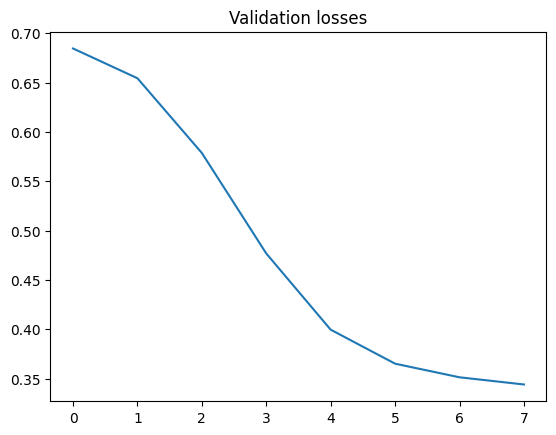

In [48]:
# Creating the MLP model
model = nn.Sequential(
    nn.Linear(11, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
)

# Initializing the BCEWithLogitsLoss as loss function and Adam optimizer as optimizer
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Variable to keep store the losses on the validation set through the training
losses = []

# Training loop
for epoch in range(8):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    loss, _, _ = evaluate_model(val_dataloader, model, loss_fn)
    losses.append(loss)

print("Done!")

# Plotting the losses
plt.plot(losses)
plt.title("Validation losses")
plt.show()

In [49]:
# Evaluating the model on the test set and sacing the loss, the f1 score and the balanced accuracy metrics
loss, f1, balanced_acc = evaluate_model(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 83.70%, 
 Avg loss: 0.4221, 
 f1 score: 0.8661 
 Balanced accuracy: 0.8260 



# Saving the model and the test metrics (commented out)

In [ ]:
# Saving the model parameters
#torch.save(model.state_dict(), "trained_models/MLP.pth")

# Saving the results as a data frame
#output_df = pd.DataFrame({"Model": ["MLP"], "Test f1-score": [f1], "Test balanced accuracy": [balanced_acc]})
#output_df.to_parquet("./results/MLP")
#output_df

,Model,Test f1-score,Test balanced accuracy
0,MLP,0.866071,0.826044


# Visualizing with SHAP

In [93]:
# Getting the shap values of the test set
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)[:, :, 0]

/var/folders/jr/_lkl4v697jlbznhrwjmhr1t00000gn/T/ipykernel_55302/2956758848.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, df_test.drop("HeartDisease", axis=1))


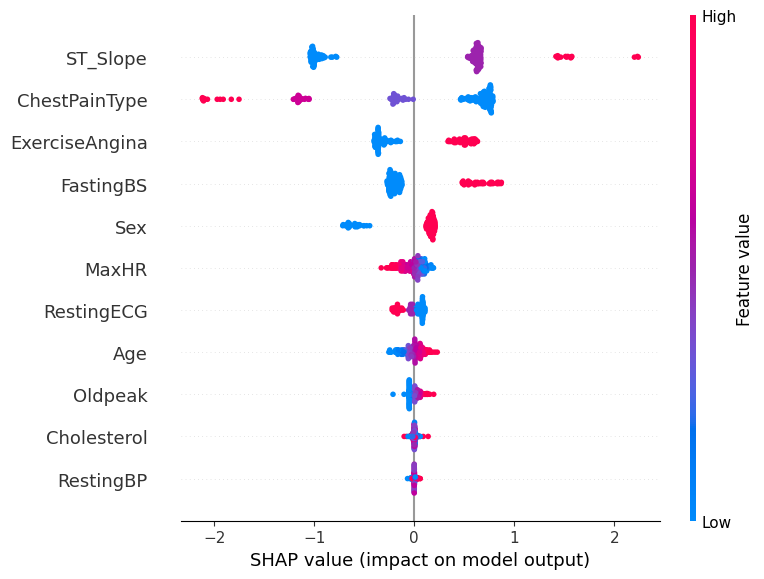

In [94]:
# Summary plot of shap values
shap.summary_plot(shap_values, df_test.drop("HeartDisease", axis=1))

In [144]:
# Getting 2-2 indices where the outcome was heart disease and non heart disease respectively
preds = model(X_test).sigmoid().round().squeeze().detach().numpy()
indexes = np.where(preds == 1)[0][:2]
indexes = np.append(indexes, np.where(preds == 0)[0][:2])
print(indexes)

[ 0  1  6 12]


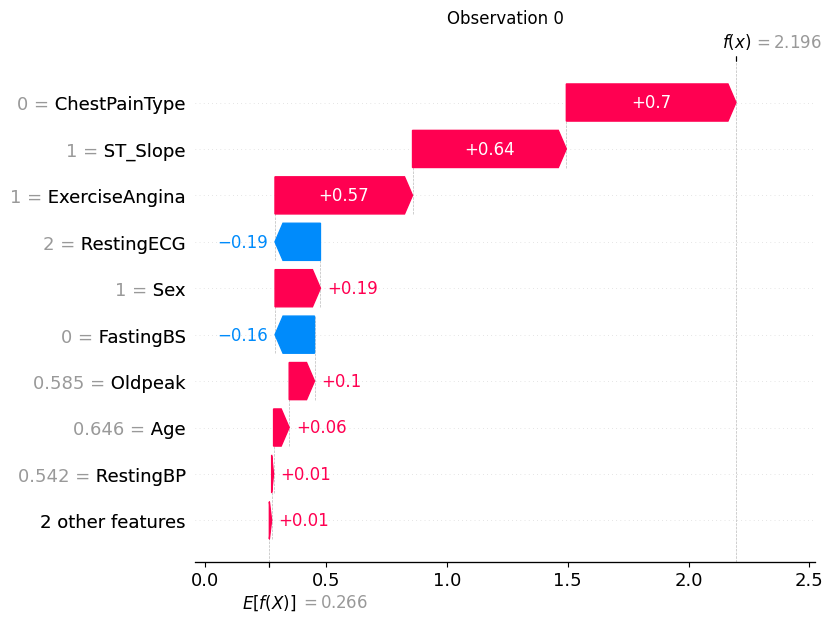

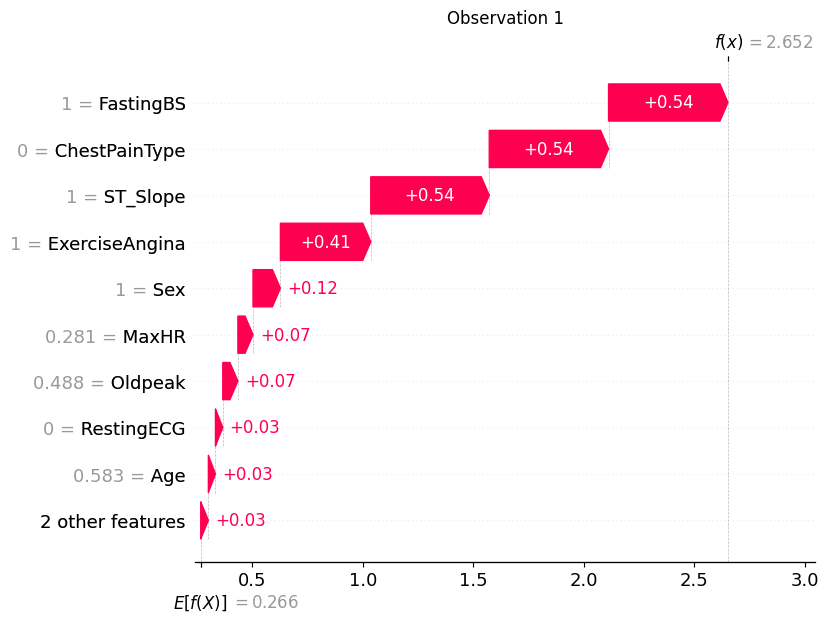

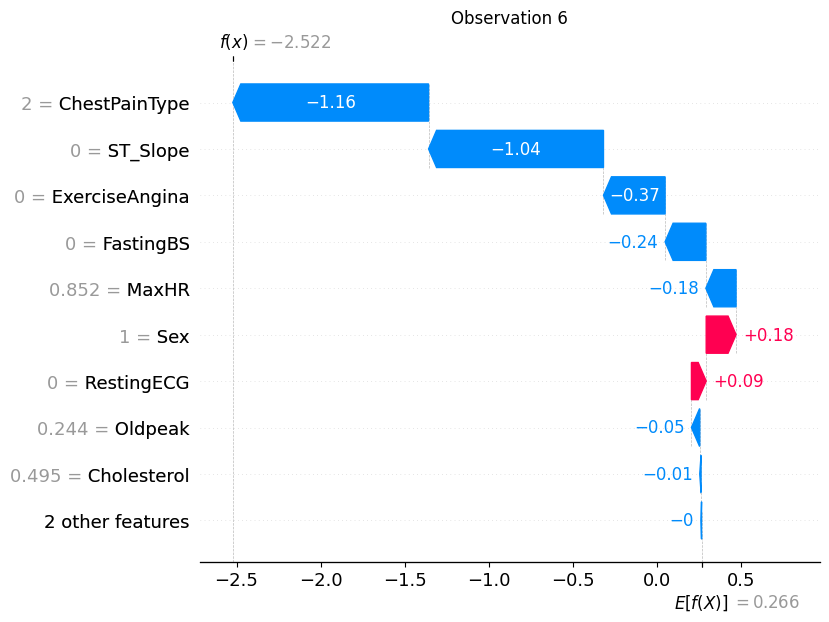

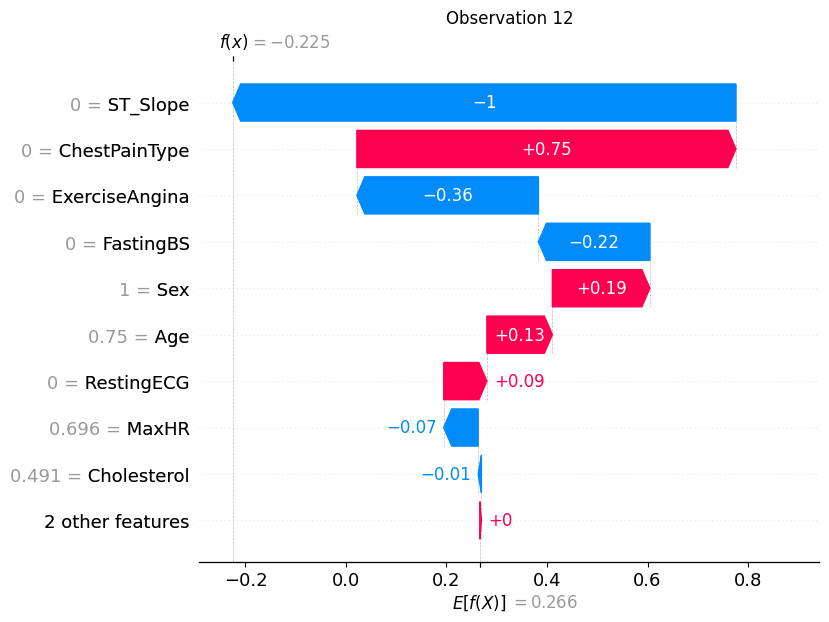

In [145]:
for i in indexes:    
    explanation = shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value[0],
        data=X_test[i].numpy(),
        feature_names=all_vars
    )
    plt.title(f"Observation {i}")

    shap.waterfall_plot(explanation)
    plt.show()

In [53]:
# Force plot of shap values
shap.force_plot(explainer.expected_value, shap_values, df_test.drop("HeartDisease", axis=1))